# Dec 26th, 2022 (AD: full brn, FC cos dist, mega)

**Motivation**: visualize differences in functional connectivity using cosine distance (focus on mega animal here) <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register, reset_ants_img
from sklearn.cluster import KMeans

mice = Mice(128, load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## Load

### Adj

In [3]:
adj = np.load(pjoin(tmp_dir, 'AD_adj.npy'), allow_pickle=True).item()
len(adj), 348 + 118 + 69 + 2

(537, 537)

### Node2id (was: Node2Region)

In [4]:
n2i = np.load(pjoin(tmp_dir, 'AD_n2i.npy'), allow_pickle=True).item()
i2n = {i: n for n, i in n2i.items()}

n2l = {}
for n, i in n2i.items():
    info = mice.parcel.get(i)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

## Explore MegaAnimal

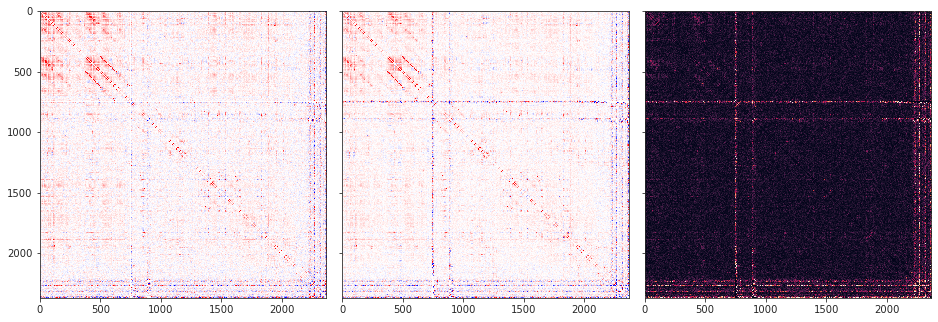

In [5]:
fig, axes = create_figure(1, 3, (13, 4.3), 'all', 'all', constrained_layout=True)
axes[0].imshow(adj['WT'], vmin=-0.1, vmax=0.1, cmap='bwr')
axes[1].imshow(adj['DKI'], vmin=-0.1, vmax=0.1, cmap='bwr')
delta = np.abs(adj['WT'] - adj['DKI'])
axes[2].imshow(delta, vmin=0, vmax=0.1, cmap='rocket')
plt.show()

### Cosine sim

In [6]:
d = sp_dist.cdist(
    XA=adj['WT'],
    XB=adj['DKI'],
    metric='cosine',
) / 2
sim = 1 - d
d.shape

(2368, 2368)

In [7]:
(np.round(np.nanmin(d), 2), np.round(np.nanmax(d), 2)), (np.round(np.nanmin(sim), 2), np.round(np.nanmax(sim), 2))

((0.05, 0.86), (0.14, 0.95))

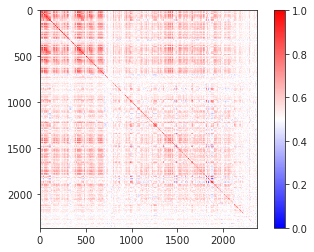

In [8]:
plt.imshow(sim, vmin=0, vmax=1, cmap='bwr')
plt.colorbar();

In [9]:
d = d.diagonal()
sim = sim.diagonal()

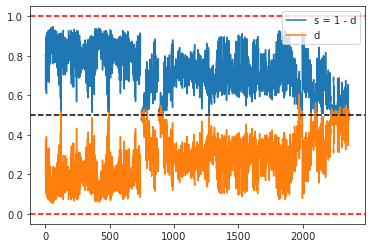

In [10]:
plt.plot(sim, label='s = 1 - d')
plt.plot(d, label='d')
plt.axhline(0, color='r', ls='--')
plt.axhline(1, color='r', ls='--')
plt.axhline(0.5, color='k', ls='--')
plt.legend()
plt.show()

In [12]:
root = mice.al.get_masks('root')
brn = mice.parcel['brain'][:]
delta = np_nans(brn.shape)
for n, i in n2i.items():
    delta[brn == i] = d[n]

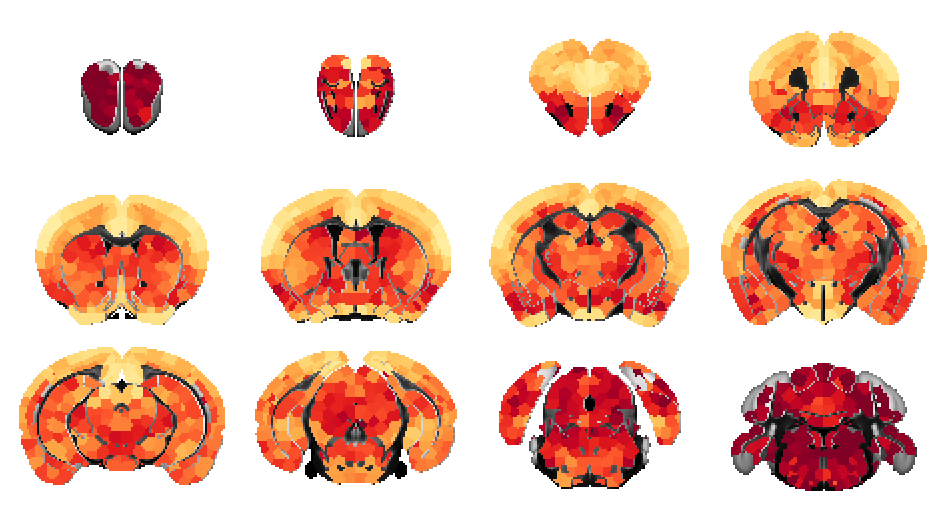

In [13]:
slices = range(10, 111, 9)

fig, axes = create_figure(3, 4, (13, 7), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], mice.al.template[s_]), cmap='Greys_r')
    ax.imshow(delta[s_], cmap='YlOrRd', vmin=0, vmax=0.5)
remove_ticks(axes)
plt.show()

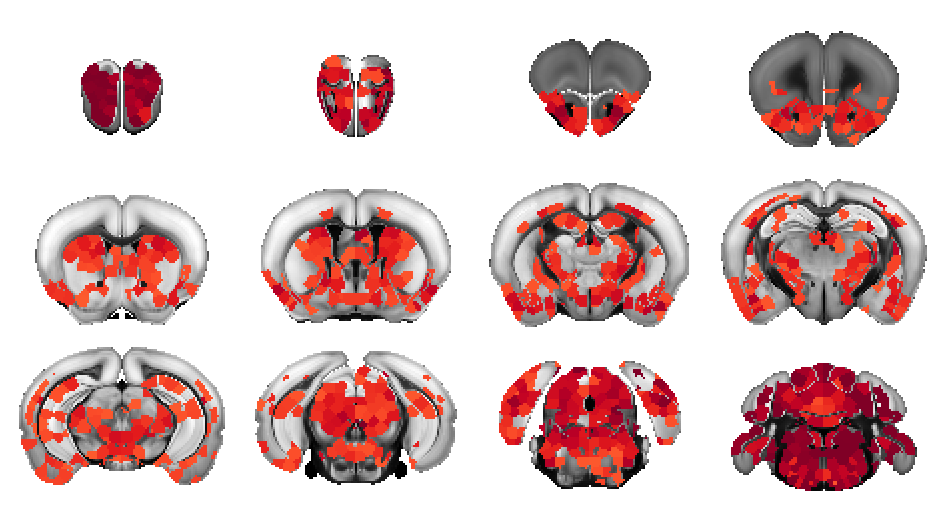

In [85]:
slices = range(10, 111, 9)

fig, axes = create_figure(3, 4, (13, 7), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], mice.al.template[s_]), cmap='Greys_r')
    ax.imshow(mwh(delta[s_] < 0.3, delta[s_]), cmap='YlOrRd', vmin=0, vmax=0.5)
remove_ticks(axes)
plt.show()

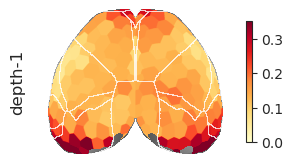

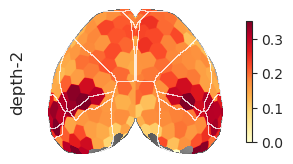

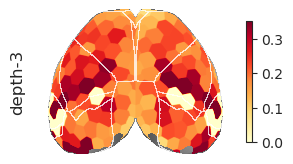

In [14]:
for i in range(3):
    _ = bs.show(
        data={f'depth-{i + 1}\n': d},
        layer=i,
        vmin=0,
        vmax=0.35,
        cbar=True,
        cbar_shrink=0.8,
        cbar_pad=0.1,
        cmap='YlOrRd',
        figsize=(3, 2.),
        proj='top',
        contour=True,
    )

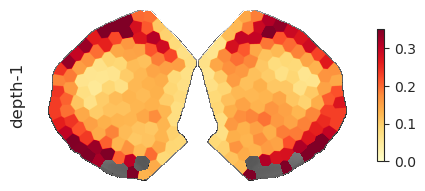

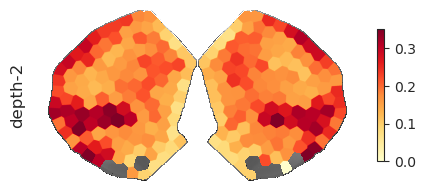

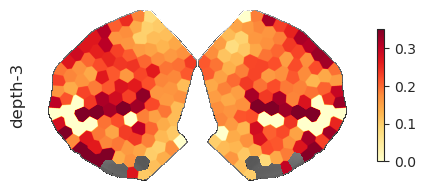

In [15]:
for i in range(3):
    _ = bs.show(
        data={f'depth-{i + 1}\n': d},
        layer=i,
        vmin=0,
        vmax=0.35,
        cbar=True,
        cbar_shrink=0.7,
        cbar_pad=0.08,
        cmap='YlOrRd',
        figsize=(5, 2.5),
        proj='flat',
        contour=False,
    )

In [16]:
df_brn = []
for n, i in n2i.items():
    info = mice.parcel(i)
    info['d'] = d[n]
    df_brn.append({
        k: [v] for k, v in info.items()
        if k not in ['id', 'region']
    })
df_brn = pd.DataFrame(merge_dicts(df_brn))

In [17]:
meanprops = {
    'marker': 'o',
    'markerfacecolor': 'bisque',
    'markeredgecolor': 'k',
    'markersize': 8,
    'alpha': 1.0,
}
props_box = {
    'y': 'd',
    'showmeans': True,
    'meanprops': meanprops,
    'width': 0.7,
}

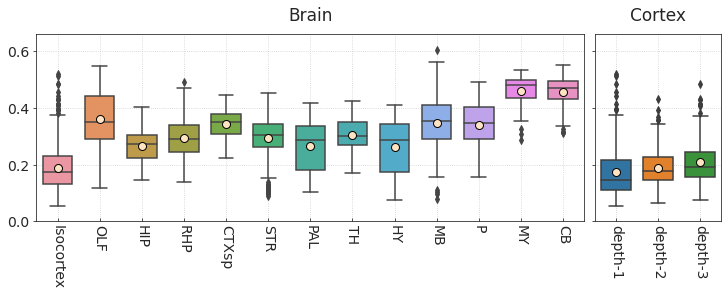

In [18]:
fig, axes = create_figure(1, 2, (10, 4), sharey='all', width_ratios=[13/3, 1], constrained_layout=True)
sns.boxplot(data=df_brn, x='acro', ax=axes[0], **props_box)
sns.boxplot(data=df_brn.loc[df_brn['acro'] == 'Isocortex'], x='layer', ax=axes[1], **props_box)
axes[1].set_xticklabels([
    f"depth-{i + 1}"
    for i in range(3)
])
axes[0].set_title(f"Brain", fontsize=17, y=1.04)
axes[1].set_title(f"Cortex", fontsize=17, y=1.04)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', rotation=-90, direction='in')
    ax.set(xlabel='', ylabel='', ylim=(0, 0.66))
    ax.grid()
plt.show()

In [19]:
df_ctx = []
for n, i in n2i.items():
    info = mice.parcel.get(i)
    if info['acro'] != 'Isocortex':
        continue
    info['affil'] = bs.affil['regions_affil_max'][info['region']]
    info['d'] = d[n]
    df_ctx.append({
        k: [v] for k, v in info.items()
        if k not in ['id', 'region']
    })
df_ctx = pd.DataFrame(merge_dicts(df_ctx))

In [20]:
props_box = {
    'x': 'affil',
    'y': 'd',
    'order': bs.affil['colors'],
    'palette': bs.affil['colors'],
    'boxprops': {
        'edgecolor': 'k',
        #'facecolor': 'none',
        'alpha': None,
        'lw': 1.5,
        'ls': '-'},
    'medianprops': {'color': 'k', 'alpha': 1.0, 'lw': 1.5},
    'whiskerprops': {'color': 'k', 'alpha': 1.0, 'lw': 1.5},
    'capprops': {'color': 'k', 'lw': 1.5, 'alpha': 1.0, 'zorder': 3},
    # 'flierprops': {'alpha': 0.0, 'zorder': 1},
    'meanprops': meanprops,
    'showfliers': True,
    'showmeans': True,
    'saturation': 0.9,
    'width': 0.75,
}

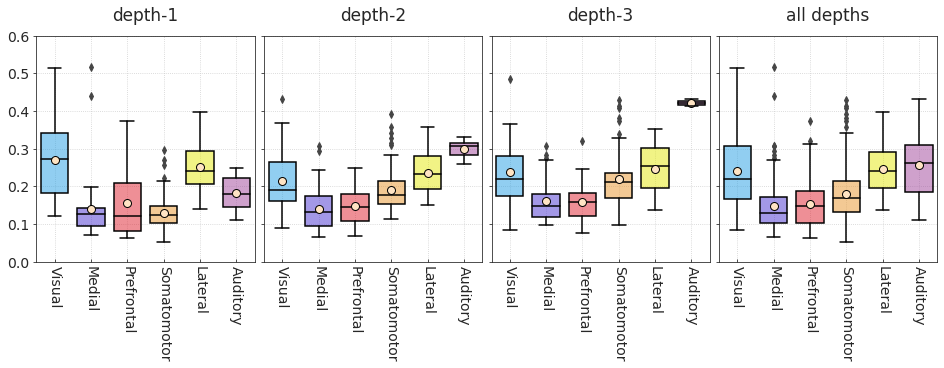

In [21]:
fig, axes = create_figure(1, 4, (13, 5), sharey='all', constrained_layout=True)
for i in range(3):
    sns.boxplot(
        data=df_ctx.loc[df_ctx['layer'] == i],
        ax=axes[i],
        **props_box,
    )
    axes[i].set_title(f"depth-{i + 1}", fontsize=17, y=1.04)
sns.boxplot(
    data=df_ctx,
    ax=axes[-1],
    **props_box,
)
axes[-1].set_title(f"all depths", fontsize=17, y=1.04)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', rotation=-90, direction='in')
    ax.set(xlabel='', ylabel='', ylim=(0, 0.6))
    ax.grid()
    for e in ax.get_children():
        if isinstance(e, PathPatch):
            fc = e.get_facecolor()
            fc = (*fc[:-1], 0.5)
            e.set_facecolor(fc)
plt.show()

In [22]:
src = ['Isocortex', 'MO', 'SS', 'SSp']
structs = []
for i in mice.al.get(src)['id']:
    tree, base_lvl = mice.al.get_subtree(
        base_id=i,
        n_levels=2,
        show=False,
    )
    nodes = []
    for n in tree.nodes:
        if tree.level(n) == 1:
            nodes.append(n)
    nodes = mice.al(nodes)['acronym']
    structs.extend(nodes.values.tolist())
structs = [e for e in structs if e not in src]
masks = mice.al.get_masks(structs)
len(masks)

25

In [23]:
%%time

id2area = {}
for i in mice.parcel.df.loc[
    (mice.parcel.df['acro'] == 'Isocortex') &
    (mice.parcel.df['hemis'] == 1), 'id'].unique():
    info = mice.parcel(i)
    max_match = np.argmax([
        overlap_score(m, brn == i)
        for k, m in masks.items()
    ])
    area = list(masks)[max_match]
    id2area[i] = area
    id2area[i + mice.parcel.num_ctx_rois() // 2] = area
id2area = dict(sorted(id2area.items()))

CPU times: user 40.8 s, sys: 0 ns, total: 40.8 s
Wall time: 40.8 s


In [43]:
df_area = []
for i, n in i2n.items():
    if i not in id2area:
        continue
    info = {
        'area': id2area[i],
        **mice.parcel(i),
        'd': d[n],
    }
    df_area.append({
        k: [v] for k, v in info.items()
        if k not in ['id', 'region', 'acro']
    })
df_area = pd.DataFrame(merge_dicts(df_area))

In [44]:
df_area

,area,hemis,layer,d
0,ORB,1,0,0.198307
1,ORB,1,0,0.194693
2,ORB,1,0,0.372576
3,ORB,1,0,0.106601
4,AI,1,0,0.374882
...,...,...,...,...
735,RSP,2,2,0.117274
736,VIS,2,2,0.299643
737,RSP,2,2,0.180081
738,RSP,2,2,0.198727


In [47]:
df_area['area'].unique()

array(['ORB', 'AI', 'FRP', 'MOs', 'MOp', 'PL', 'GU', 'ILA', 'SSp-m',
       'SSs', 'ACA', 'VISC', 'SSp-ul', 'SSp-n', 'ECT', 'SSp-bfd', 'TEa',
       'AUD', 'SSp-ll', 'RSP', 'SSp-tr', 'PTLp', 'VIS'], dtype=object)

In [80]:
props_box = {
    'x': 'area',
    'y': 'd',
    'order': df_area['area'].unique(),
    'meanprops': meanprops,
    'showmeans': True,
    'width': 0.7,
}

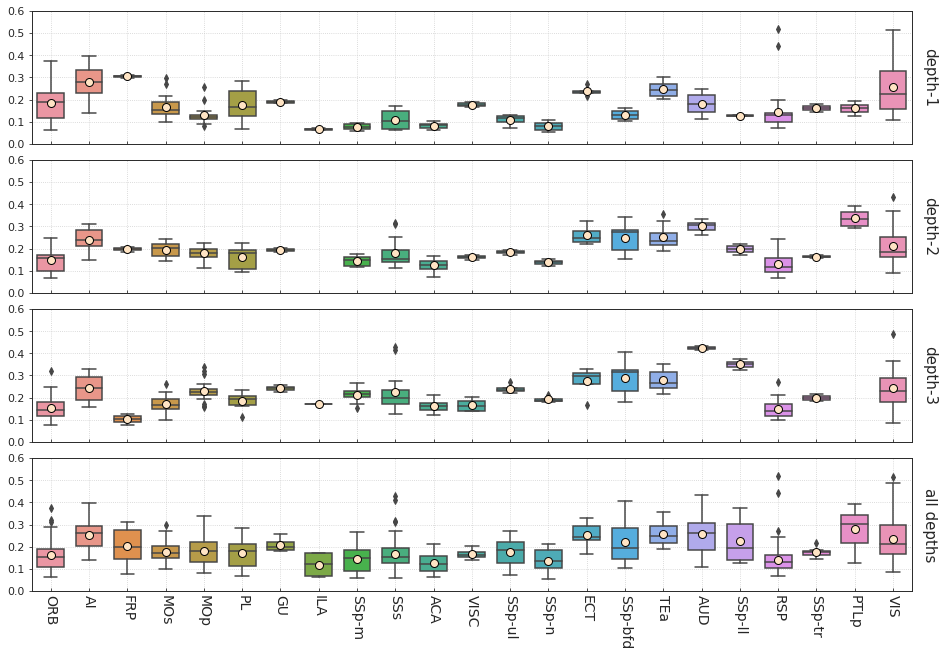

In [81]:
fig, axes = create_figure(4, 1, (13, 9), 'all', 'all', constrained_layout=True)

for i in range(3):
    ax = axes[i]
    sns.boxplot(data=df_area.loc[df_area['layer'] == i], ax=ax, **props_box)
    axtw = ax.twinx()
    axtw.set_ylabel(f"depth-{i + 1}", rotation=-90, fontsize=15, labelpad=25)
    axtw.set_yticks([])
    
ax = axes[-1]
sns.boxplot(data=df_area, ax=ax, **props_box)
axtw = ax.twinx()
axtw.set_ylabel('all depths', rotation=-90, fontsize=15, labelpad=25)
axtw.set_yticks([])
    
for ax in axes.flat:
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=14, rotation=-90, direction='in')
    ax.set(xlabel='', ylabel='', ylim=(0, 0.6))
    ax.grid()